<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-11-28 13:37:37--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2019-11-28 13:37:38 (11.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

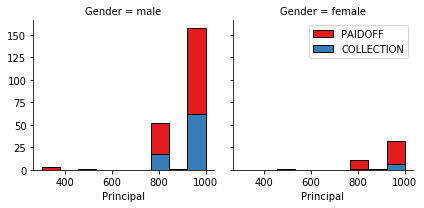

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

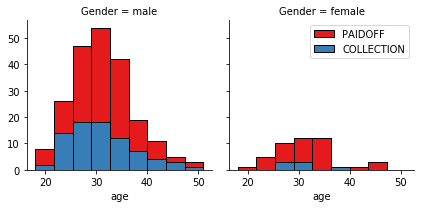

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

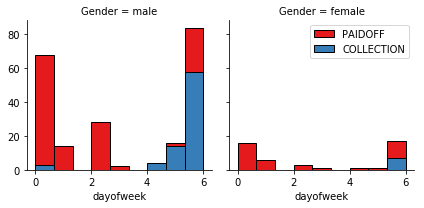

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [18]:
y = df['loan_status'].values
y[:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
# importing libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score, f1_score, accuracy_score

#### I prefer calling it <u>X_val</u> instead than X_test because later on we will have a different X_test
#### and I think it could be confusing

In [21]:
# splitting the training dataset into X_train and X_val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=4)

In [22]:
mean_acc = np.zeros((9))
std_acc = np.zeros((9))
for n in range(1,10): 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_val)
    mean_acc[n-1] = metrics.accuracy_score(y_val, yhat)
    std_acc[n-1]=np.std(yhat==y_val)/np.sqrt(yhat.shape[0])
mean_acc

array([0.73563218, 0.71264368, 0.75862069, 0.73563218, 0.79310345,
       0.7816092 , 0.79310345, 0.7816092 , 0.77011494])

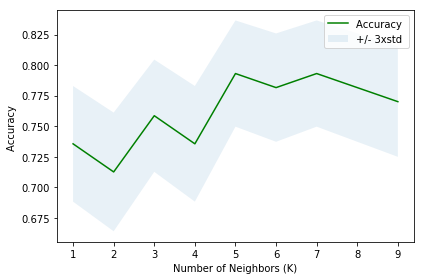

In [23]:
plt.plot(range(1,10),mean_acc,'g')
plt.fill_between(range(1,10),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

#### <u>the (smallest) best k is 5</u>
#### time to build the model and perform the predictions

In [24]:
neigh = KNeighborsClassifier(n_neighbors = 5).fit(X_train,y_train)

In [25]:
# evaluating
print("KNN Train Set Accuracy: ", accuracy_score(y_train, neigh.predict(X_train)))
print("KNN Validation Set Accuracy: ", accuracy_score(y_val, neigh.predict(X_val)))

KNN Train Set Accuracy:  0.806949806949807
KNN Validation Set Accuracy:  0.7931034482758621


#### Now we will create the model that is fitted on the whole dataset. We'll call it <u>model_knn</u>.

In [26]:
model_knn = KNeighborsClassifier(n_neighbors = 5).fit(X,y)

# Decision Tree

In [27]:
# importing libraries
from sklearn.tree import DecisionTreeClassifier

In [28]:
# building the model
# (max_depth is put to 6 to limit overfitting)
dectree = DecisionTreeClassifier(criterion="entropy", max_depth=6).fit(X_train, y_train)

In [29]:
# evaluating
print("DT Train set Accuracy: ", accuracy_score(y_train, dectree.predict(X_train)))
print("DT Validation set Accuracy: ", accuracy_score(y_val, dectree.predict(X_val)))

DT Train set Accuracy:  0.7722007722007722
DT Validation set Accuracy:  0.7471264367816092


#### Now we will create the model that is fitted on the whole dataset. We'll call it <u>model_dt</u>.

In [30]:
model_dt = DecisionTreeClassifier(criterion="entropy", max_depth=6).fit(X, y)

# Support Vector Machine

In [31]:
# importing library
from sklearn import svm

In [32]:
# building the model
suvemac = svm.SVC(kernel="rbf").fit(X_train, y_train)  

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [33]:
# evaluating
print("SVM Train set Accuracy: ", accuracy_score(y_train, suvemac.predict(X_train)))
print("SVM Validation set Accuracy: ", accuracy_score(y_val, suvemac.predict(X_val)))

SVM Train set Accuracy:  0.7606177606177607
SVM Validation set Accuracy:  0.7471264367816092


#### Now we will create the model that is fitted on the whole dataset. We'll call it <u>model_svm</u>.

In [34]:
model_svm = svm.SVC(kernel="rbf").fit(X, y) 

# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [36]:
logreg = LogisticRegression(C=0.01, solver="liblinear").fit(X_train,y_train)

In [37]:
# evaluating
print("Logistic Regression Train set Accuracy: ", accuracy_score(y_train, logreg.predict(X_train)))
print("Logistic Regression Validation set Accuracy: ", accuracy_score(y_val, logreg.predict(X_val)))

Logistic Regression Train set Accuracy:  0.7644787644787645
Logistic Regression Validation set Accuracy:  0.7126436781609196


#### Now we will create the model that is fitted on the whole dataset. We'll call it <u>model_lr</u>.

In [38]:
model_lr = LogisticRegression(C=0.01, solver="liblinear").fit(X,y)

# Model Evaluation using Test set

In [39]:
# importing libraries
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [40]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-11-28 13:41:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-11-28 13:41:25 (48.9 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [41]:
# loading Test Set
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [42]:
# converting datetime into datetime format
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])

In [43]:
# creating dayofweek column
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

In [44]:
# producing the weekend column
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [45]:
# getting dummies
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,female,0,1,0,0
1,300,7,35,male,1,0,0,0
2,1000,30,43,female,1,0,1,0
3,1000,30,26,male,1,0,0,1
4,800,15,29,male,1,1,0,0


In [46]:
# converting Gender in 0,1
test_feature['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [47]:
# normalizing the test data
X_test = preprocessing.StandardScaler().fit(test_feature).transform(test_feature)
X_test[:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [48]:
# targetting result
y_test = test_df['loan_status'].values
y_test[:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [49]:
# creating lists for the final report #1
list_jaccard = []
list_f1 = []
list_logloss = []

# creating list for final report #2
list_jaccard_100 = []
list_f1_100 = []
list_logloss_100 = []

In [50]:
# KNN
knn_pred_100 = model_knn.predict(X_test)
knn_pred = neigh.predict(X_test)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    list_jaccard.append(jaccard_similarity_score(y_test, knn_pred))
    list_jaccard_100.append(jaccard_similarity_score(y_test, knn_pred_100))
list_f1.append(f1_score(y_test, knn_pred, average='weighted'))
list_f1_100.append(f1_score(y_test, knn_pred_100, average='weighted'))
list_logloss.append('NA')
list_logloss_100.append('NA')

In [51]:
# Decision Tree
tree_pred_100 = model_dt.predict(X_test)
tree_pred = dectree.predict(X_test)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    list_jaccard.append(jaccard_similarity_score(y_test, tree_pred))
    list_jaccard_100.append(jaccard_similarity_score(y_test, tree_pred_100))
list_f1.append(f1_score(y_test, tree_pred, average='weighted'))
list_f1_100.append(f1_score(y_test, tree_pred_100, average='weighted'))
list_logloss.append('NA')
list_logloss_100.append('NA')

In [52]:
# SVM
svm_pred_100 = model_svm.predict(X_test)
svm_pred = suvemac.predict(X_test)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    list_jaccard.append(jaccard_similarity_score(y_test, svm_pred))
    list_jaccard_100.append(jaccard_similarity_score(y_test, svm_pred_100))
list_f1.append(f1_score(y_test, svm_pred, average='weighted'))
list_f1_100.append(f1_score(y_test, svm_pred_100, average='weighted'))
list_logloss.append('NA')
list_logloss_100.append('NA')

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
# Logistic Regression
log_pred_100 = model_lr.predict(X_test)
proba_100 = model_lr.predict_proba(X_test)
log_pred = logreg.predict(X_test)
proba = logreg.predict_proba(X_test)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    list_jaccard.append(jaccard_similarity_score(y_test, log_pred))
    list_jaccard_100.append(jaccard_similarity_score(y_test, log_pred_100))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    list_f1.append(f1_score(y_test, log_pred, average='weighted')) 
    list_f1_100.append(f1_score(y_test, log_pred_100, average='weighted')) 
list_logloss.append(log_loss(y_test, proba))
list_logloss_100.append(log_loss(y_test, proba_100))

In [54]:
# building the report nr 1
report_01 = pd.DataFrame(list_jaccard, index=['KNN','Decision Tree','SVM','Logistic Regression'])
report_01.columns = ['Jaccard']
report_01.insert(loc=1, column='F1-score', value=list_f1)
report_01.insert(loc=2, column='LogLoss', value=list_logloss)
report_01.columns.name = 'Algorithm trained on 75% of the dataset'
report_01

Algorithm trained on 75% of the dataset,Jaccard,F1-score,LogLoss
KNN,0.703704,0.686067,NA
Decision Tree,0.796296,0.798519,NA
SVM,0.740741,0.630418,NA
Logistic Regression,0.759259,0.671764,0.570728


#### With the model fitted on X_train, we get the best value of the Jaccard Similarity Index with Decision Tree

In [55]:
# building the report nr 2
report_02 = pd.DataFrame(list_jaccard_100, index=['KNN','Decision Tree','SVM','Logistic Regression'])
report_02.columns = ['Jaccard']
report_02.insert(loc=1, column='F1-score', value=list_f1)
report_02.insert(loc=2, column='LogLoss', value=list_logloss)
report_02.columns.name = 'Algorithm trained on the whole dataset'
report_02

Algorithm trained on the whole dataset,Jaccard,F1-score,LogLoss
KNN,0.740741,0.686067,NA
Decision Tree,0.740741,0.798519,NA
SVM,0.722222,0.630418,NA
Logistic Regression,0.740741,0.671764,0.570728


#### With the model fitted on the whole X, results are worse for 3 algorithms, better just for KNN.